In [1]:
import pandas as pd
import numpy as np
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# use get_db_url function to connect to the codeup db
from env import get_db_url
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


import zillow_wrangle

In [2]:
# Bringing in the zillow data set
df = zillow_wrangle.wrangle_zillow()

In [3]:
# the wrangle function cut off roughly 7000 results
df.shape

(79661, 22)

In [4]:
df = zillow_wrangle.latlong_to_cart(df)

In [5]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,latitude,longitude,taxamount,lotsizesquarefeet,rawcensustractandblock,...,lat,long,bed_bath_ratio,house_age,coslat,coslong,sinlong,x,y,z
0,3.0,2.0,1614.0,1106837.0,1923.0,34045401.0,-118433920.0,13343.01,6767.0,6.037267e+07,...,34.045401,-118.433920,1.500000,94.0,-0.871708,0.584445,0.811434,-0.509465,-0.707334,-0.775711
1,3.0,2.0,1409.0,295907.0,1962.0,33814427.0,-118033546.0,3519.46,6000.0,6.059110e+07,...,33.814427,-118.033546,1.500000,55.0,-0.736380,0.221957,0.975056,-0.163445,-0.718012,0.960066
2,4.0,4.0,1906.0,610663.0,1929.0,33952853.0,-118443334.0,7430.75,5520.0,6.037278e+07,...,33.952853,-118.443334,1.000000,88.0,-0.822692,0.592057,0.805896,-0.487081,-0.663004,0.651727
3,2.0,2.0,1839.0,300205.0,1963.0,34078654.0,-117877174.0,3895.71,7119.0,6.037404e+07,...,34.078654,-117.877174,1.000000,54.0,-0.887518,0.067398,0.997726,-0.059817,-0.885500,0.997168
4,4.0,3.0,2316.0,399945.0,1967.0,34440226.0,-119295368.0,4912.24,11463.0,6.111001e+07,...,34.440226,-119.295368,1.333333,50.0,-0.993129,0.996377,0.085050,-0.989531,-0.084466,0.967165


In [6]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

df['rho'], df['phi'] = cart2pol(df.x, df.y)

In [7]:
df = zillow_wrangle.keep_col(df)

In [8]:
df.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       13
taxvaluedollarcnt                   1
yearbuilt                          46
latitude                            0
longitude                           0
taxamount                           6
lotsizesquarefeet                1572
rawcensustractandblock              0
roomcnt                             0
poolcnt                             0
regionidcounty                      0
garagecarcnt                        0
logerror17                      14751
logerror16                      62961
transaction17                   14751
transaction16                   62961
lat                                 0
long                                0
bed_bath_ratio                      0
house_age                          46
coslat                              0
coslong                             0
sinlong                             0
x                                   0
y           

The null values for log error and transaction is a result from the sql query. I will merge them so that there are no null values in those two columns
Due to the small size of the other nulls, I will just drop them from the data frame

In [9]:
df['logerror'] = 0
df.loc[~df['logerror17'].isnull(), 'logerror'] = df.loc[~df['logerror17'].isnull(), 'logerror17']
df.loc[~df['logerror16'].isnull(), 'logerror'] = df.loc[~df['logerror16'].isnull(), 'logerror16']
df['transactiondate'] = None
df.loc[~df['transaction17'].isnull(), 'transactiondate'] = df.loc[~df['transaction17'].isnull(), 'transaction17']
df.loc[~df['transaction16'].isnull(), 'transactiondate'] = df.loc[~df['transaction16'].isnull(), 'transaction16']


zillow_wrangle(df)

In [10]:
df.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       13
taxvaluedollarcnt                   1
yearbuilt                          46
latitude                            0
longitude                           0
taxamount                           6
lotsizesquarefeet                1572
rawcensustractandblock              0
roomcnt                             0
poolcnt                             0
regionidcounty                      0
garagecarcnt                        0
logerror17                      14751
logerror16                      62961
transaction17                   14751
transaction16                   62961
lat                                 0
long                                0
bed_bath_ratio                      0
house_age                          46
coslat                              0
coslong                             0
sinlong                             0
x                                   0
y           

In [11]:
df = df.drop(columns= ['transaction16','transaction17', 'logerror16', 'logerror17'])

In [12]:
df.isnull().sum()

bedroomcnt                         0
bathroomcnt                        0
calculatedfinishedsquarefeet      13
taxvaluedollarcnt                  1
yearbuilt                         46
latitude                           0
longitude                          0
taxamount                          6
lotsizesquarefeet               1572
rawcensustractandblock             0
roomcnt                            0
poolcnt                            0
regionidcounty                     0
garagecarcnt                       0
lat                                0
long                               0
bed_bath_ratio                     0
house_age                         46
coslat                             0
coslong                            0
sinlong                            0
x                                  0
y                                  0
z                                  0
rho                                0
phi                                0
logerror                           0
t

In [13]:
def add_date_features(df):
    
    df['transactiondate'] = pd.to_datetime(df['transactiondate'], format= '%Y/%m/%d')

    df["transaction_month"] = df["transactiondate"].dt.month
    
    df["transaction_quarter"] = df["transactiondate"].dt.quarter

    df.drop(["transactiondate"], inplace=True, axis=1)
    
    return df

In [14]:
df = df.dropna()

In [15]:
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
latitude                        0
longitude                       0
taxamount                       0
lotsizesquarefeet               0
rawcensustractandblock          0
roomcnt                         0
poolcnt                         0
regionidcounty                  0
garagecarcnt                    0
lat                             0
long                            0
bed_bath_ratio                  0
house_age                       0
coslat                          0
coslong                         0
sinlong                         0
x                               0
y                               0
z                               0
rho                             0
phi                             0
logerror                        0
transactiondate                 0
dtype: int64

In [16]:
df = add_date_features(df)

In [17]:
df.transaction_quarter.value_counts()

3    27632
2    25094
1    18299
4     7010
Name: transaction_quarter, dtype: int64

In [18]:
df.transaction_month.value_counts()

9     11711
6      9433
5      8564
8      8097
7      7824
3      7532
4      7097
1      5603
2      5164
10     4081
11     1523
12     1406
Name: transaction_month, dtype: int64

In [19]:
train, validate, test = zillow_wrangle.split_data(df)

In [20]:
train.shape, validate.shape, test.shape

((49942, 29), (12486, 29), (15607, 29))

In [21]:

def scatter_vs_target(df, target, cat=None):
    for col in df:
        sns.scatterplot(data=df, x=col, y=target, hue=cat)
        plt.show()

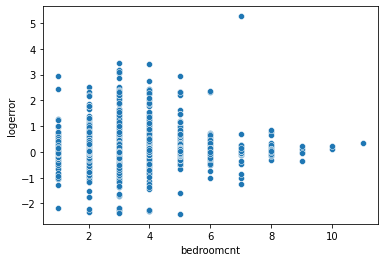

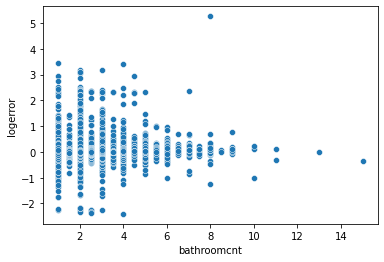

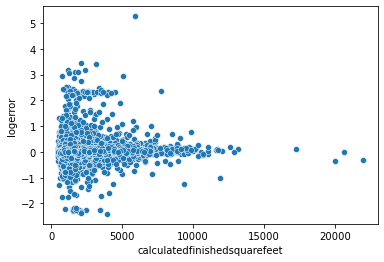

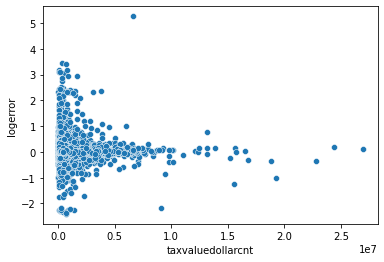

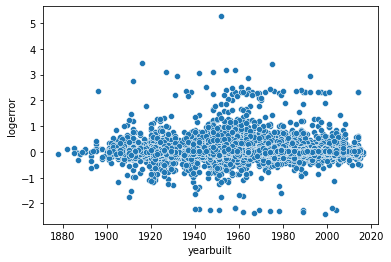

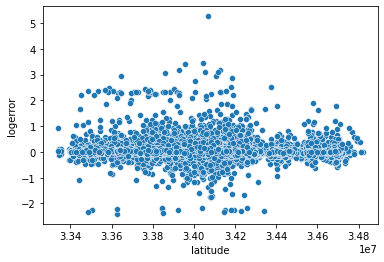

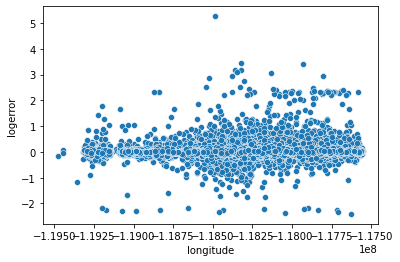

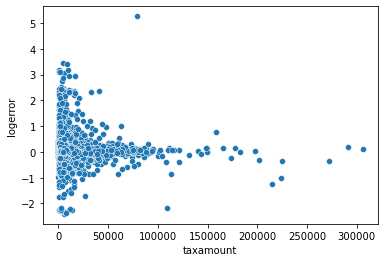

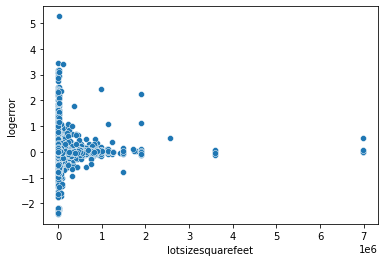

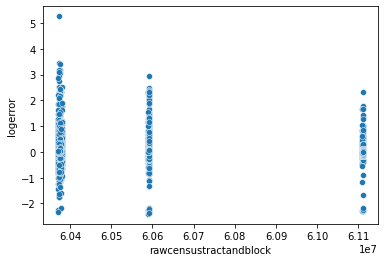

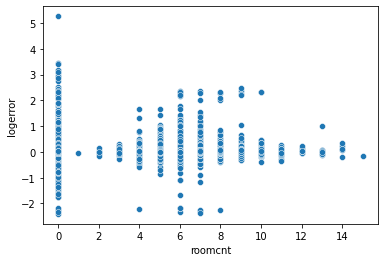

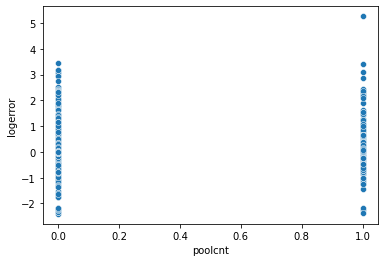

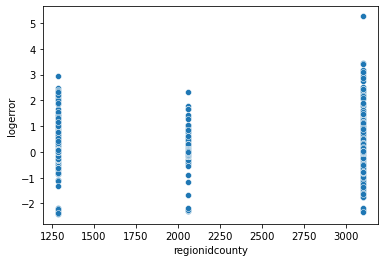

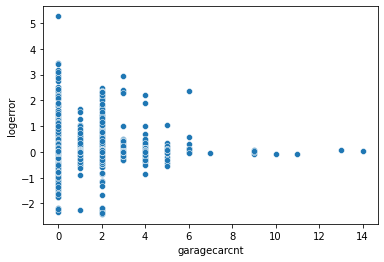

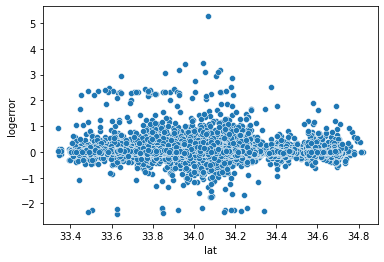

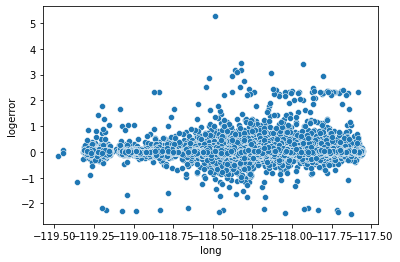

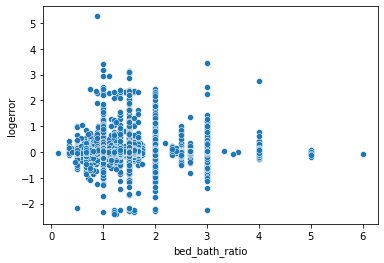

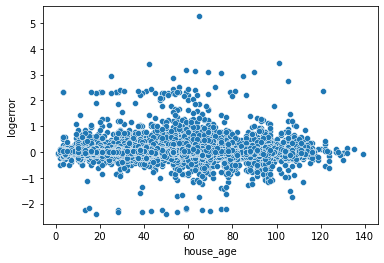

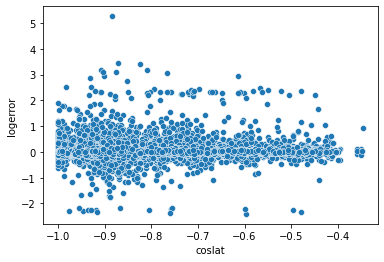

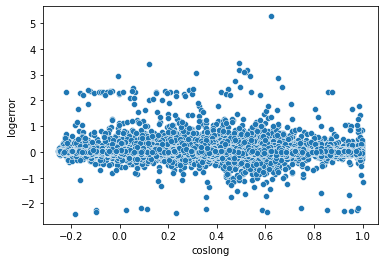

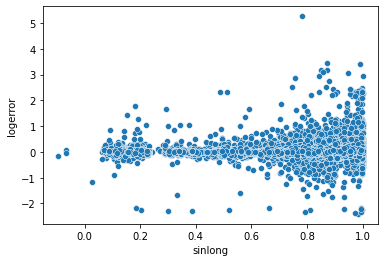

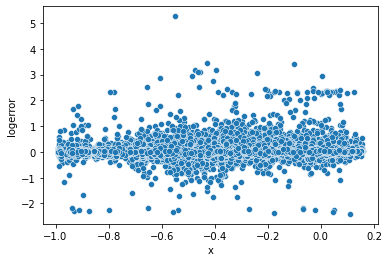

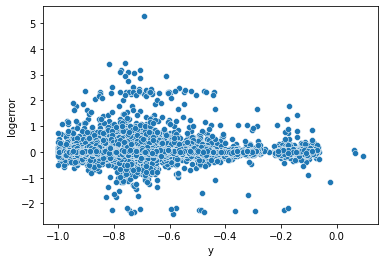

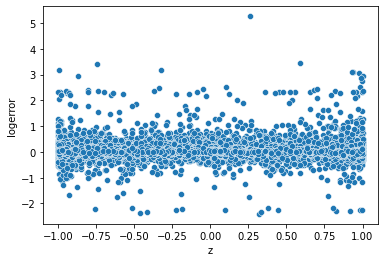

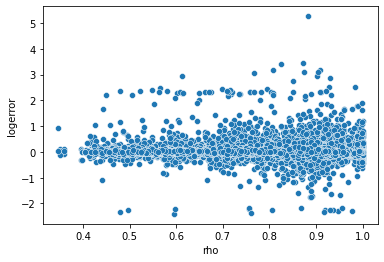

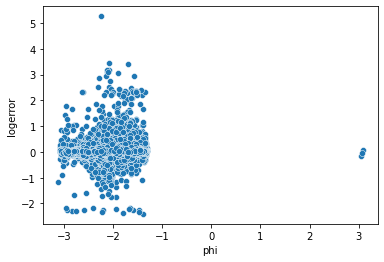

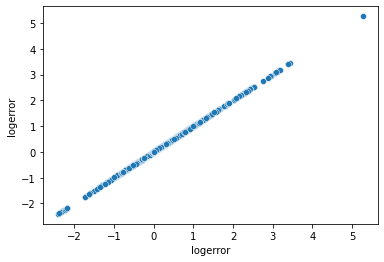

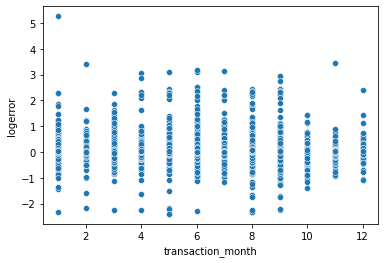

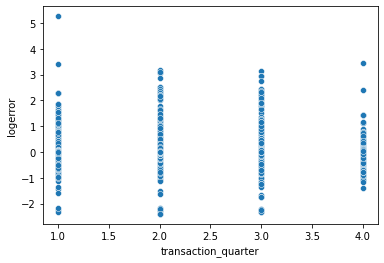

In [22]:
scatter_vs_target(train, 'logerror')

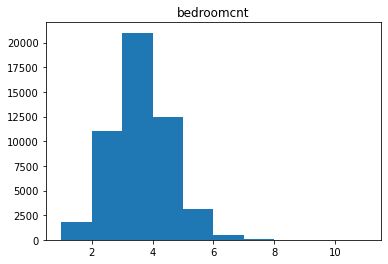

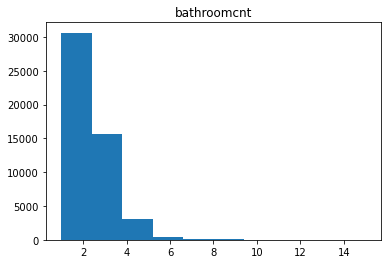

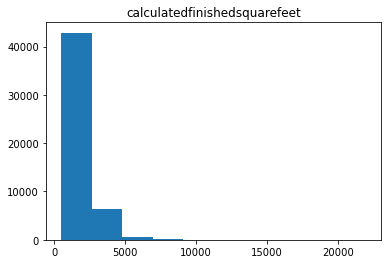

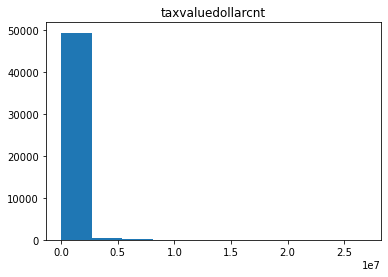

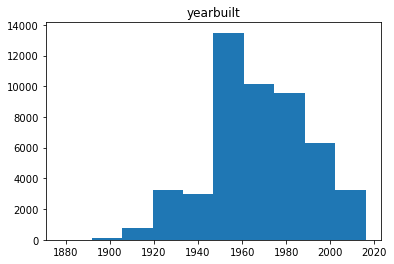

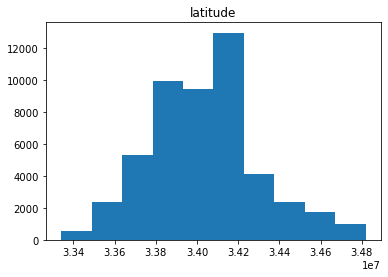

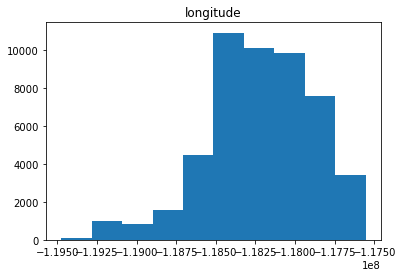

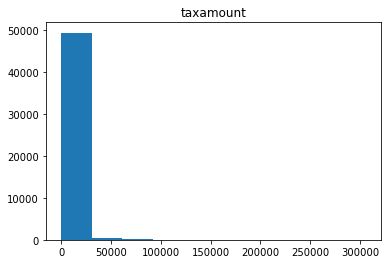

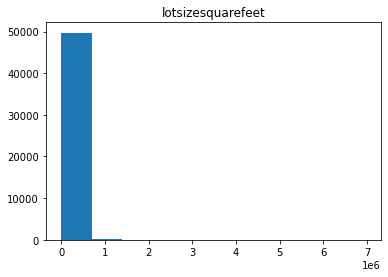

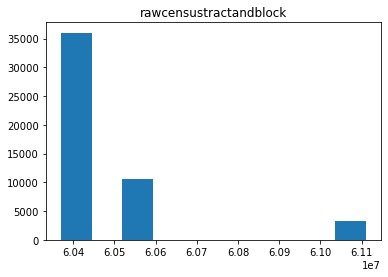

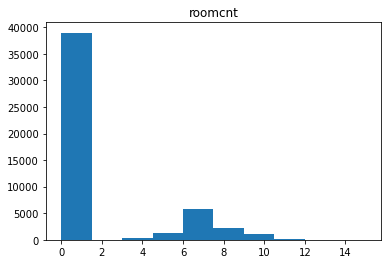

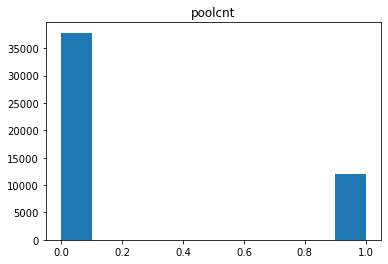

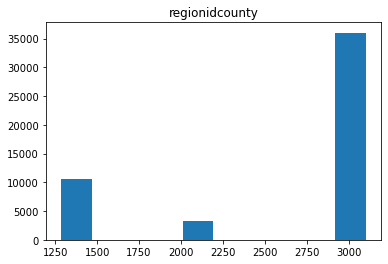

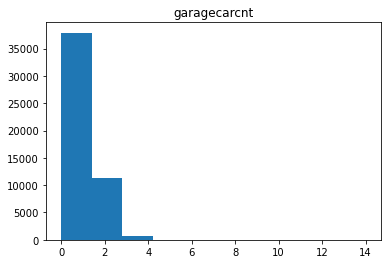

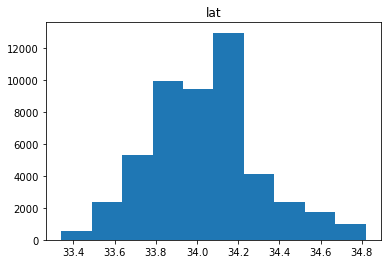

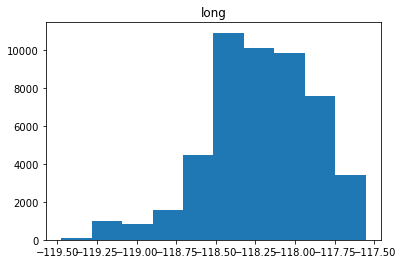

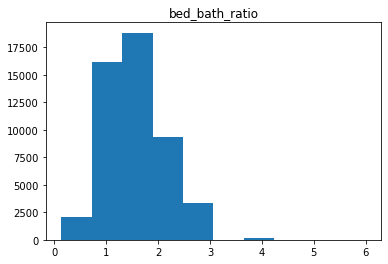

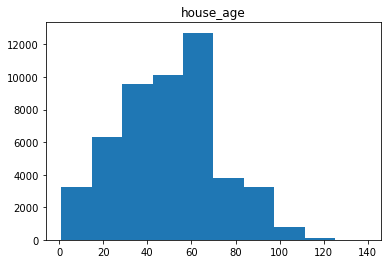

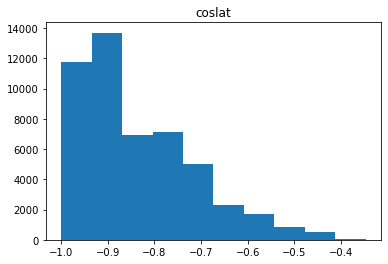

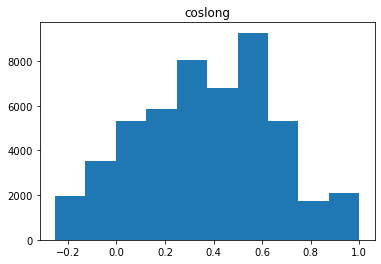

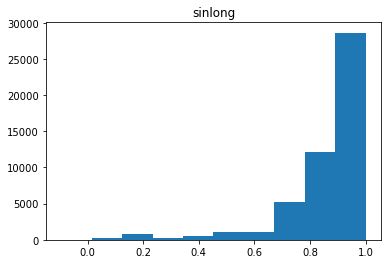

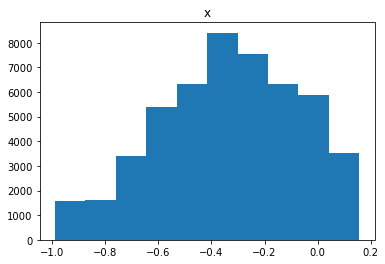

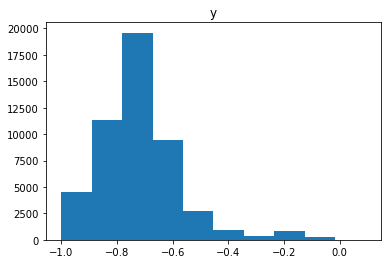

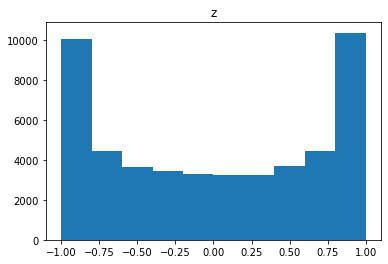

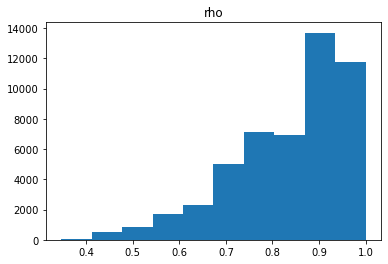

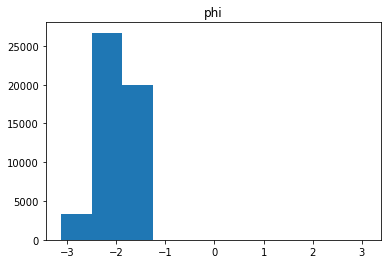

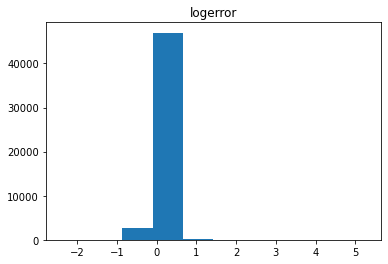

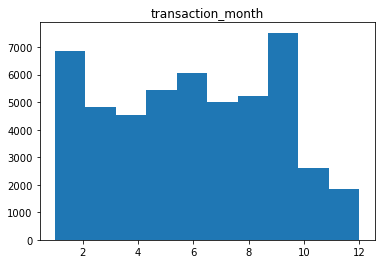

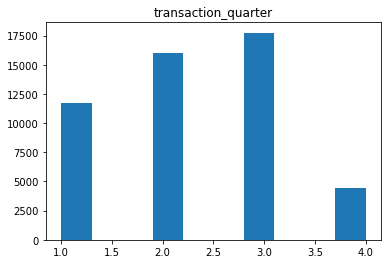

In [23]:
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [24]:
logmean = train.logerror.mean()

In [25]:
train.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'yearbuilt', 'latitude', 'longitude', 'taxamount',
       'lotsizesquarefeet', 'rawcensustractandblock', 'roomcnt', 'poolcnt',
       'regionidcounty', 'garagecarcnt', 'lat', 'long', 'bed_bath_ratio',
       'house_age', 'coslat', 'coslong', 'sinlong', 'x', 'y', 'z', 'rho',
       'phi', 'logerror', 'transaction_month', 'transaction_quarter'],
      dtype='object')

In [26]:
# cutting the only most extreme outliers and will handle with a robust scaler later
train = zillow_wrangle.remove_outliers(train, 4, ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'garagecarcnt'])
train.shape

(48861, 29)

In [27]:
def county_name(county):
    if county == 2061.0:
        return 'Los Angeles'
    elif county == 1286.0:
        return 'Orange'
    elif county == 3101.0:
        return 'Ventura'

train['county'] = train.regionidcounty.apply(county_name)

# 

---

## Question 1 Does log error vary by county


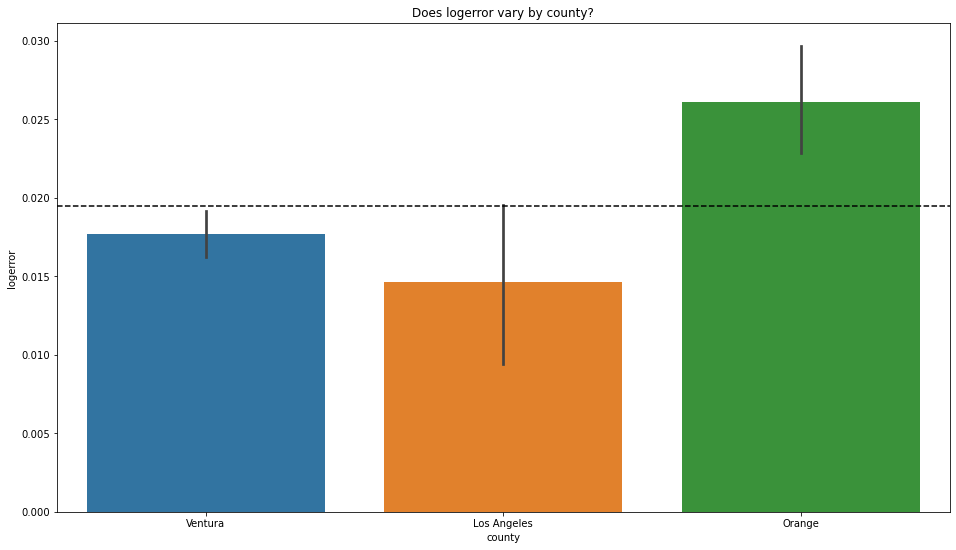

In [28]:
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='county', y='logerror')
plt.title('Does logerror vary by county?')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

## Q2 - Do polar coordinate by bin have different log error?

In [29]:
train['polar_combo'] = train.rho * train.phi

train['polar_bin'] = pd.qcut(train['polar_combo'],q=6)


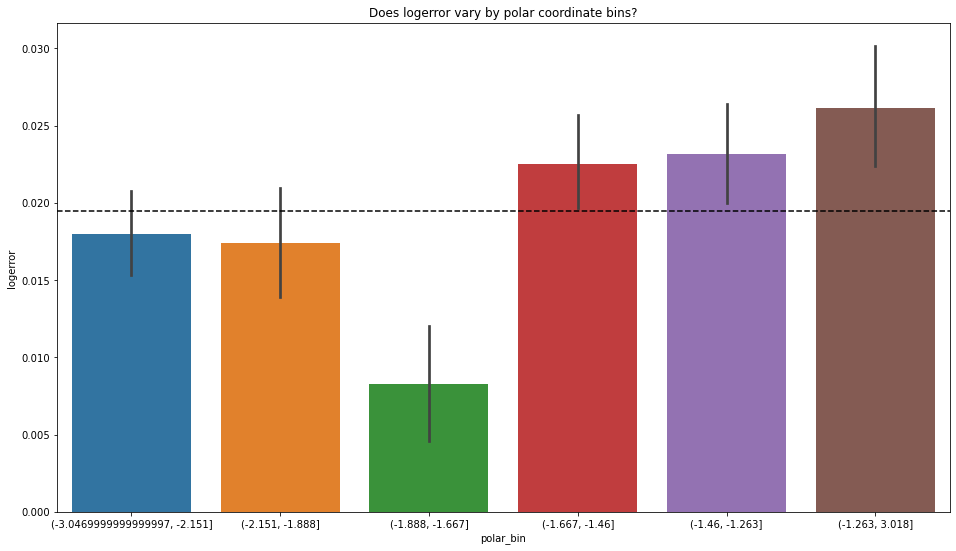

In [30]:
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='polar_bin', y='logerror')
plt.title('Does logerror vary by polar coordinate bins?')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

# Q3 - Does transaction date affect log error?

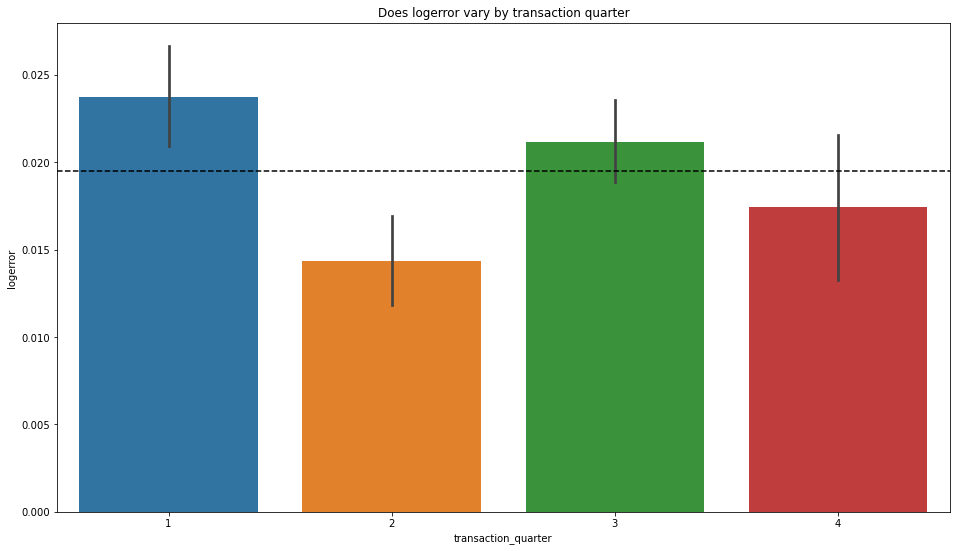

In [31]:
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='transaction_quarter', y='logerror')
plt.title('Does logerror vary by transaction quarter')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

## Q 3

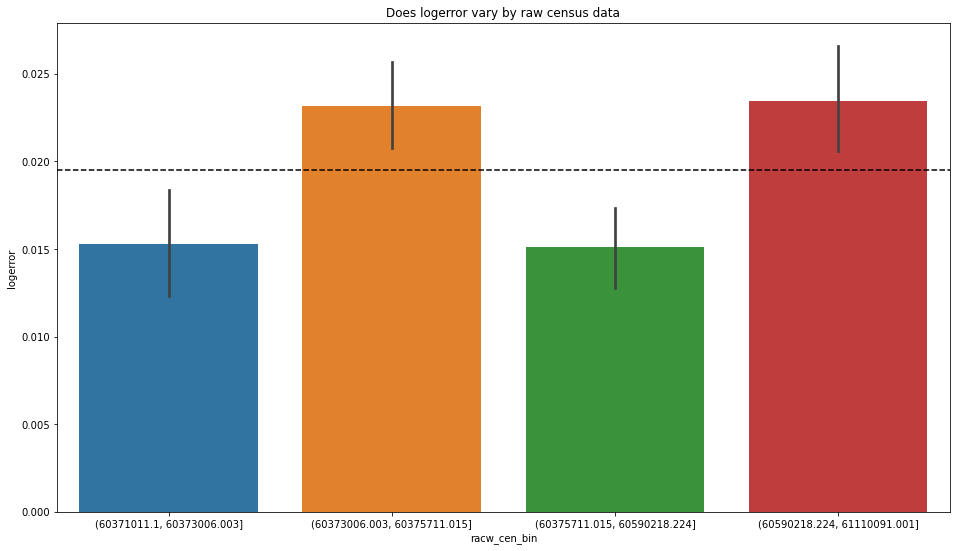

In [32]:
train['racw_cen_bin'] = pd.qcut(train['rawcensustractandblock'],q=4)

plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='racw_cen_bin', y='logerror')
plt.title('Does logerror vary by raw census data')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

In [33]:
train.racw_cen_bin.value_counts()

(60371011.1, 60373006.003]      12217
(60375711.015, 60590218.224]    12215
(60590218.224, 61110091.001]    12215
(60373006.003, 60375711.015]    12214
Name: racw_cen_bin, dtype: int64

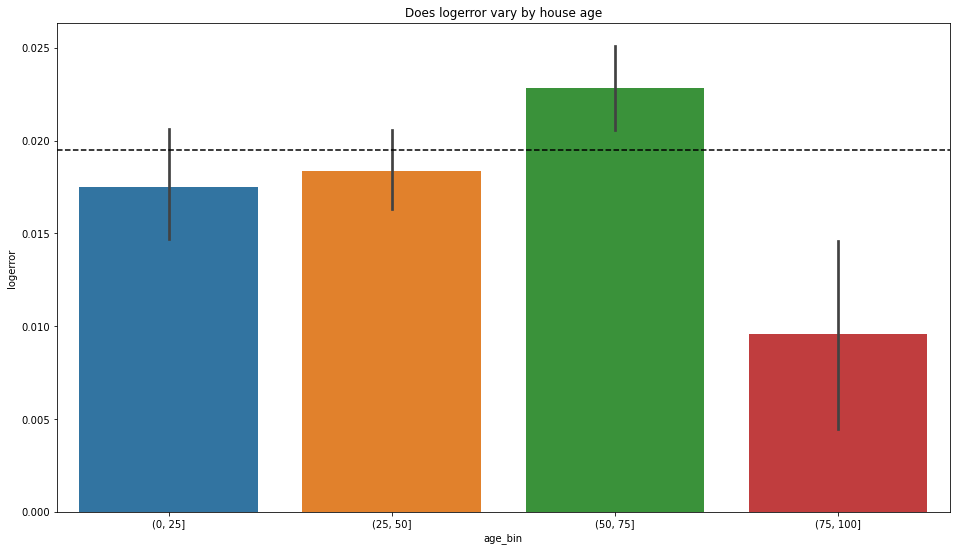

In [51]:
train['age_bin'] = pd.cut(train.house_age,[0,25, 50, 75, 100])

plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='age_bin', y='logerror')
plt.title('Does logerror vary by house age')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

In [34]:
train['weird_ratio'] = df.calculatedfinishedsquarefeet * df.bed_bath_ratio

In [35]:
train['weird_bin'] = pd.qcut(train['weird_ratio'],q=6)


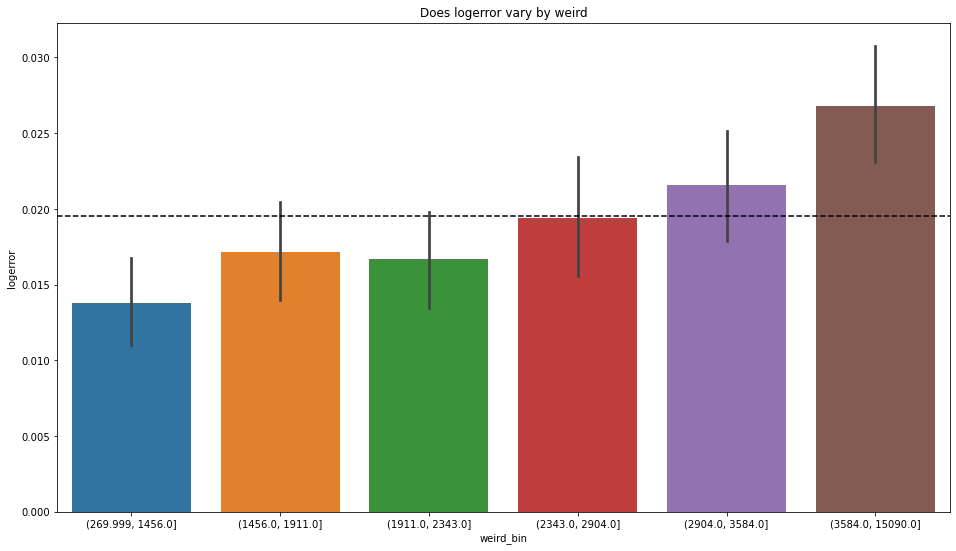

In [36]:
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='weird_bin', y='logerror')
plt.title('Does logerror vary by weird')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

#
---

Cluster time

In [37]:
train.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'yearbuilt', 'latitude', 'longitude', 'taxamount',
       'lotsizesquarefeet', 'rawcensustractandblock', 'roomcnt', 'poolcnt',
       'regionidcounty', 'garagecarcnt', 'lat', 'long', 'bed_bath_ratio',
       'house_age', 'coslat', 'coslong', 'sinlong', 'x', 'y', 'z', 'rho',
       'phi', 'logerror', 'transaction_month', 'transaction_quarter', 'county',
       'polar_combo', 'polar_bin', 'racw_cen_bin', 'weird_ratio', 'weird_bin'],
      dtype='object')

In [40]:
cols_to_scale = train.drop(columns= ['age_bin', 'racw_cen_bin', 'polar_bin', 'weird_bin', 'county', 'logerror'])
robust = RobustScaler()
# train_robust = pd.DataFrame(robust.fit_transform(train[cols_to_scale])), index=train.index, columns=train.columns)

In [41]:



clusters = pd.DataFrame(robust.fit_transform(cols_to_scale),index=cols_to_scale.index, columns=cols_to_scale.columns)

<AxesSubplot:xlabel='polar_combo', ylabel='weird_ratio'>

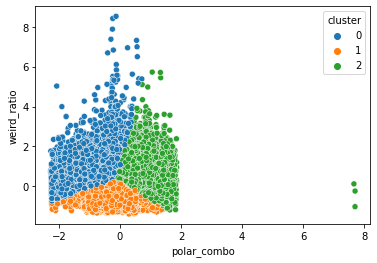

In [50]:
X1 = clusters[['weird_ratio', 'polar_combo']]

# Make the model
kmeans = KMeans(n_clusters=3)

# Fit the model
kmeans.fit(X1)
kmeans.predict(X1)

# add cluster column for visualization
clusters['cluster'] = kmeans.predict(X1)
clusters.cluster = clusters.cluster.astype('category')
clusters.head()

# visualize the cluster
sns.scatterplot(data=clusters, y = 'weird_ratio', x = 'polar_combo', hue= 'cluster')

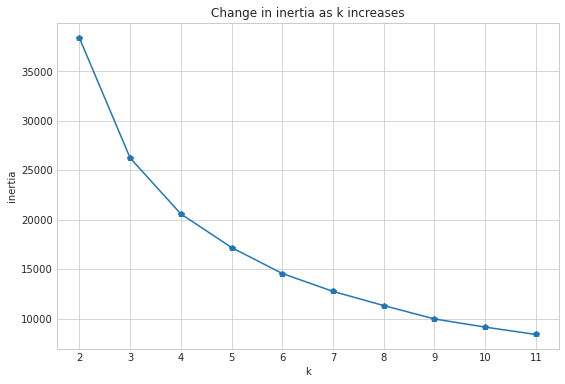

In [49]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X1).inertia_ for k in range(2, 12)}).plot(marker='p')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

<AxesSubplot:xlabel='house_age', ylabel='calculatedfinishedsquarefeet'>

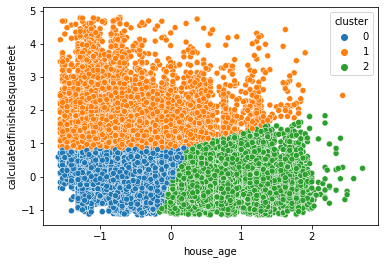

In [48]:
X2 = clusters[['house_age', 'calculatedfinishedsquarefeet']]

# Make the model
kmeans = KMeans(n_clusters=3)

# Fit the model
kmeans.fit(X2)
kmeans.predict(X2)

# add cluster column for visualization
clusters['cluster'] = kmeans.predict(X2)
clusters.cluster = clusters.cluster.astype('category')
clusters.head()

# visualize the cluster
sns.scatterplot(data=clusters, y = 'calculatedfinishedsquarefeet', x = 'house_age', hue= 'cluster')

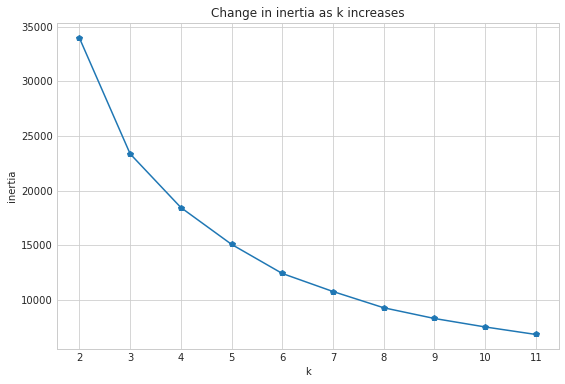

In [47]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, 12)}).plot(marker='p')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

<AxesSubplot:xlabel='house_age', ylabel='calculatedfinishedsquarefeet'>

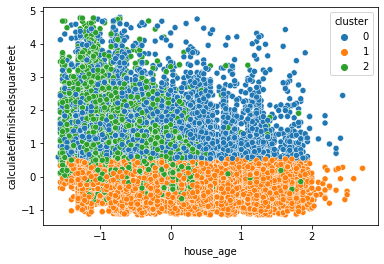

In [52]:
X3 = clusters[['garagecarcnt', 'calculatedfinishedsquarefeet']]

# Make the model
kmeans = KMeans(n_clusters=3)

# Fit the model
kmeans.fit(X3)
kmeans.predict(X3)

# add cluster column for visualization
clusters['cluster'] = kmeans.predict(X3)
clusters.cluster = clusters.cluster.astype('category')
clusters.head()

# visualize the cluster
sns.scatterplot(data=clusters, y = 'calculatedfinishedsquarefeet', x = 'house_age', hue= 'cluster')

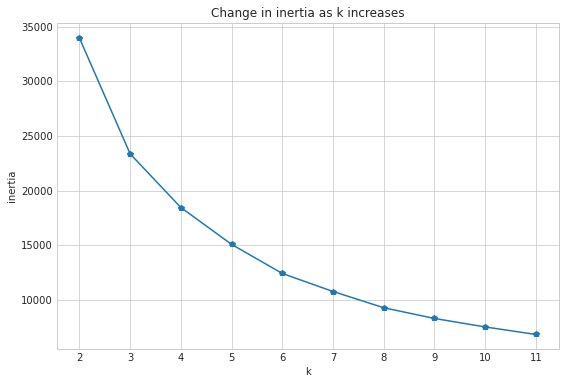

In [53]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, 12)}).plot(marker='p')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

cols_to_scale = train.drop(columns= ['age_bin', 'racw_cen_bin', 'polar_bin', 'weird_bin', 'county', 'logerror'])

clusters

In [56]:
scaled_train = pd.concat([train[['age_bin', 'racw_cen_bin', 'polar_bin', 'weird_bin', 'county', 'logerror']], clusters],axis=1) 